In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


In [2]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [3]:
dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
           "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
           "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
           "soil" : pd.read_csv("../src/soil_data.csv"),
           }

In [ ]:
# dataDic["train"].columns

In [ ]:
# dataDic["soil"]

In [6]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [7]:
dfs = {
    k: dataDic[k].set_index(['fips', 'date'])
    for k in dataDic.keys() if k != "soil"
}

dfs["soil"] = dataDic["soil"]

In [8]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
embeddings_dim = [570, 20, 20, 20, 20, 20, 20, 20]
one_cycle = True
lr = 7e-5 # 9e-5
epochs = 15
clip = 5


In [9]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

In [10]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

In [11]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [12]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [ ]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train", use_prev_year=True)
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True, use_prev_year=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True, use_prev_year=True)
# print("test shape", X_time_test.shape)

In [14]:
# # Save all in pickle
# import pickle
# with open("data.pkl", "wb") as f:
#     pickle.dump(
#         {
#             "X_tabular_train": X_tabular_train,
#             "X_time_train": X_time_train,
#             "y_target_train": y_target_train,
#             "X_tabular_validation": X_tabular_validation,
#             "X_time_valid": X_time_valid,
#             "y_target_valid": y_target_valid,
#             "valid_fips": valid_fips,
#             "X_tabular_test": X_tabular_test,
#             "X_time_test": X_time_test,
#             "y_target_test": y_target_test,
#             "test_fips": test_fips,
#         },
#         f,
#     )

In [15]:
# import
import pickle
with open("data.pkl", "rb") as f:
    data = pickle.load(f)
    X_tabular_train = data["X_tabular_train"]
    X_time_train = data["X_time_train"]
    y_target_train = data["y_target_train"]
    X_tabular_validation = data["X_tabular_validation"]
    X_time_valid = data["X_time_valid"]
    y_target_valid = data["y_target_valid"]
    valid_fips = data["valid_fips"]
    X_tabular_test = data["X_tabular_test"]
    X_time_test = data["X_time_test"]
    y_target_test = data["y_target_test"]
    test_fips = data["test_fips"]


In [16]:
X_tabular_train.shape

(97099, 30)

In [17]:
ordered_cols = sorted([c for c in dfs["soil"].columns if c not in ["soil", "lat", "lon"]])

In [18]:
cat_cols = [ordered_cols.index(i) for i in ["fips", "SQ1", "SQ2", "SQ3", "SQ4", "SQ5", "SQ6", "SQ7"]]

In [19]:
cat_cols

[21, 6, 7, 8, 9, 10, 11, 12]

In [20]:
X_tabular_cat_train = X_tabular_train[:,cat_cols].astype(int)
X_tabular_train = X_tabular_train[:,[i for i in range(X_tabular_train.shape[1]) if i not in cat_cols]]

X_tabular_cat_valid = X_tabular_validation[:,cat_cols].astype(int)
X_tabular_validation = X_tabular_validation[:,[i for i in range(X_tabular_validation.shape[1]) if i not in cat_cols]]

X_tabular_cat_test = X_tabular_test[:,cat_cols].astype(int)
X_tabular_test = X_tabular_test[:,[i for i in range(X_tabular_test.shape[1]) if i not in cat_cols]]

In [21]:
X_tabular_cat_test.shape

(2477, 8)

In [22]:
dico_trad = {}
for cat in range(X_tabular_cat_train.shape[1]):
    dico_trad[cat] = {j: i for i,j in enumerate(sorted(np.unique_values(X_tabular_cat_train[:,cat])))}
    dico_trad[cat]["unknown"] = len(np.unique_values(X_tabular_cat_train[:,cat]))

In [23]:
dico_trad[0]

{np.int64(1001): 0,
 np.int64(1003): 1,
 np.int64(1005): 2,
 np.int64(1007): 3,
 np.int64(1009): 4,
 np.int64(1011): 5,
 np.int64(1013): 6,
 np.int64(1015): 7,
 np.int64(1017): 8,
 np.int64(1019): 9,
 np.int64(1021): 10,
 np.int64(1023): 11,
 np.int64(1025): 12,
 np.int64(1027): 13,
 np.int64(1029): 14,
 np.int64(1031): 15,
 np.int64(1033): 16,
 np.int64(1035): 17,
 np.int64(1037): 18,
 np.int64(1039): 19,
 np.int64(1041): 20,
 np.int64(1043): 21,
 np.int64(1045): 22,
 np.int64(1047): 23,
 np.int64(1049): 24,
 np.int64(1051): 25,
 np.int64(1053): 26,
 np.int64(1055): 27,
 np.int64(1057): 28,
 np.int64(1059): 29,
 np.int64(1061): 30,
 np.int64(1063): 31,
 np.int64(1065): 32,
 np.int64(1067): 33,
 np.int64(1069): 34,
 np.int64(1071): 35,
 np.int64(1073): 36,
 np.int64(1075): 37,
 np.int64(1077): 38,
 np.int64(1079): 39,
 np.int64(1081): 40,
 np.int64(1083): 41,
 np.int64(1085): 42,
 np.int64(1087): 43,
 np.int64(1089): 44,
 np.int64(1091): 45,
 np.int64(1093): 46,
 np.int64(1095): 47,
 n

In [24]:
for cat in range(len(cat_cols)):
    X_tabular_cat_train[:,cat] = [dico_trad[cat][i] for i in X_tabular_cat_train[:,cat]]
    X_tabular_cat_valid[:,cat] = [dico_trad[cat][i] if i in dico_trad[cat] else dico_trad[cat]["unknown"] for i in X_tabular_cat_valid[:,cat]]
    X_tabular_cat_test[:,cat] = [dico_trad[cat][i] if i in dico_trad[cat] else dico_trad[cat]["unknown"] for i in X_tabular_cat_test[:,cat]]

In [25]:
np.unique(X_tabular_cat_train[:,0])

array([   0,    1,    2, ..., 3105, 3106, 3107])

In [26]:
X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:00<00:00, 11909.48it/s]


In [27]:
#  Prepare the datasets
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    torch.tensor(X_tabular_cat_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(X_tabular_cat_valid),
    torch.tensor(y_target_valid[:, :output_weeks]),
)

# DataLoaders with sampler for training and default for validation
train_loader = DataLoader(
    train_data, batch_size=batch_size, drop_last=False
)

valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [28]:
test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(X_tabular_cat_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)

test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [29]:
len(train_loader)

759

In [30]:
list_cat = [len(np.unique(X_tabular_cat_train[:,i])) + 1 for i in range(X_tabular_cat_train.shape[1])]

In [31]:
list_cat

[3109, 8, 8, 8, 8, 8, 7, 9]

In [32]:
class HybridModel(nn.Module):
    def __init__(
        self,
        num_numerical_features,
        num_time_series_features,
        hidden_size,
        num_lstm_layers,
        list_unic_cat,
        embedding_dims,
        num_fc_tabular_layers,
        num_fc_combined_layers,
        output_size,
        dropout
    ):
        super(HybridModel, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size

        self.embeddings = nn.ModuleList(
                [
                    nn.Embedding(num_embeddings=i, embedding_dim=dimension)
                    for i, dimension in zip(list_unic_cat, embedding_dims)
                ]
            )
        
        tabular_total_size = num_numerical_features + sum(embedding_dims)
        tabular_fc_layers = []
        for _ in range(num_fc_tabular_layers):
            tabular_fc_layers.append(nn.Linear(tabular_total_size, tabular_total_size))
            tabular_fc_layers.append(nn.ReLU())
        self.tabular_fc_layers = nn.Sequential(
            *tabular_fc_layers, nn.Linear(tabular_total_size, tabular_total_size)
        )

        # TS branch
        self.lstm = nn.LSTM(
            input_size=num_time_series_features,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.attention = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

        combined_fc_layers = []
        input_dim = tabular_total_size + hidden_size

        for _ in range(num_fc_combined_layers):
            combined_fc_layers.append(nn.Linear(input_dim, hidden_size))
            combined_fc_layers.append(nn.ReLU())
            input_dim = hidden_size
        self.combined_fc_layers = nn.Sequential(
            *combined_fc_layers, nn.Linear(hidden_size, output_size)
        )

    def forward(self, time_series_data, numerical_data, categorical_data):
        batch_size = time_series_data.size(0)
        h0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)

        time_series_data = time_series_data.to(torch.float32)
        numerical_data = numerical_data.to(torch.float32)
        categorical_data = categorical_data.to(torch.int64)

        embeddings = [emb(categorical_data[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat = torch.cat(embeddings, dim=1)
        x_tabular = torch.cat((x_cat, numerical_data), dim=1)
        x1 = self.tabular_fc_layers(x_tabular)

        # Pass the time series data through the LSTM and the attention mechanism
        lstm_out, _ = self.lstm(time_series_data, (h0, c0))
        lstm_out = self.layer_norm(lstm_out) # Apply layer normalization
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        # Pass the data through the attention mechanism
        # context_vector = lstm_out[:, -1, :]  # Last time step output

        # Combined MLPs and output
        x2 = self.dropout(context_vector)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_fc_layers(x)
        return x

In [33]:
writer = SummaryWriter('../runs/attention_emb_new')

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    list_unic_cat=list_cat,
    embedding_dims=embeddings_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

model.to(device)
loss_function = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)

for i in range(epochs):
    for k, (inputs, static, static_cat, labels) in tqdm(enumerate(train_loader),
                                                       desc=f"epoch {i+1}/{epochs}",
                                                       total=len(train_loader),):
        model.train()
        counter += 1
        inputs, labels, static, static_cat = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
            static_cat.to(device),
        )
        
        model.zero_grad()
        output = model(inputs, static, static_cat)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, stat_cat, lab in valid_loader:
                    inp, lab, stat, stat_cat = inp.to(device), lab.to(device), stat.to(device), stat_cat.to(device)
                    out = model(inp, stat, stat_cat)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(MSE)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "../models/otro_hybrido.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

In [42]:
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    list_unic_cat=list_cat,
    embedding_dims=embeddings_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

model.load_state_dict(torch.load("../models/otro_hybrido.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (embeddings): ModuleList(
    (0): Embedding(3109, 570)
    (1-5): 5 x Embedding(8, 20)
    (6): Embedding(7, 20)
    (7): Embedding(9, 20)
  )
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=732, out_features=732, bias=True)
    (1): ReLU()
    (2): Linear(in_features=732, out_features=732, bias=True)
    (3): ReLU()
    (4): Linear(in_features=732, out_features=732, bias=True)
  )
  (lstm): LSTM(40, 512, num_layers=2, batch_first=True, dropout=0.1)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=1244, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [43]:
def predict(x, static, static_cat):
    out = model(torch.tensor(x), static, static_cat)
    return out

In [46]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, static_cat, y in tqdm(
    test_loader,# ou test_loader
    desc="validation predictions...",
    ):
    x, static, static_cat, y = x.to(device), static.to(device), static_cat.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static, static_cat).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1642224/1961147624.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(x), static, static_cat)
validation predictions...: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


In [47]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
VALDATION:
Week 1 MAE 0.136 F1 0.71
Week 2 MAE 0.175 F1 0.65
Week 3 MAE 0.215 F1 0.573
Week 4 MAE 0.251 F1 0.545
Week 5 MAE 0.284 F1 0.461
Week 6 MAE 0.316 F1 0.402

TEST:
Week 1 MAE 0.188 F1 0.656
Week 2 MAE 0.263 F1 0.53
Week 3 MAE 0.322 F1 0.469
Week 4 MAE 0.384 F1 0.411
Week 5 MAE 0.443 F1 0.357
Week 6 MAE 0.496 F1 0.31
"""

Week 1 MAE 0.188 F1 0.656
Week 2 MAE 0.263 F1 0.53
Week 3 MAE 0.322 F1 0.469
Week 4 MAE 0.384 F1 0.411
Week 5 MAE 0.443 F1 0.357
Week 6 MAE 0.496 F1 0.311


'\nVALDATION:\nWeek 1 MAE 0.136 F1 0.71\nWeek 2 MAE 0.175 F1 0.65\nWeek 3 MAE 0.215 F1 0.573\nWeek 4 MAE 0.251 F1 0.545\nWeek 5 MAE 0.284 F1 0.461\nWeek 6 MAE 0.316 F1 0.402\n'

In [48]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.104382,0,0.0000,0
1,0.008597,0,0.0000,0
2,0.139852,0,0.0000,0
3,0.084811,0,0.0000,0
4,-0.009141,0,0.0000,0
...,...,...,...,...
14857,2.009996,2,2.8139,5
14858,2.570912,3,3.1832,5
14859,2.160982,2,2.7126,5
14860,1.315477,1,2.0000,5


In [49]:
for cat in df["y_true"].round().astype(int).unique():
    df_cat = df[df["y_true"].round().astype(int) == cat]
    print(f"Accuracy {cat}:")
    print((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())

Accuracy 0:
0.8882130150350052
Accuracy 1:
0.5373027259684362
Accuracy 3:
0.4107505070993915
Accuracy 4:
0.30218687872763417
Accuracy 2:
0.42997685185185186
Accuracy 5:
0.027777777777777776


In [50]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
for i in range(len(y_pred_roc)):
    y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
for i in range(len(y_true_roc)):
    y_true_for_sklearn[i, int(y_true_roc[i])] = 1


mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')

results = pd.DataFrame({'Model': ["Hybrid_no_embd"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})
results

,Model,MAE,RMSE,F1,ROC_AUC
0,Hybrid_no_embd,0.349273,0.536483,0.454525,0.775669


[np.float64(0.8882130150350052), np.float64(0.5373027259684362), np.float64(0.42997685185185186), np.float64(0.4107505070993915), np.float64(0.30218687872763417), np.float64(0.027777777777777776)]


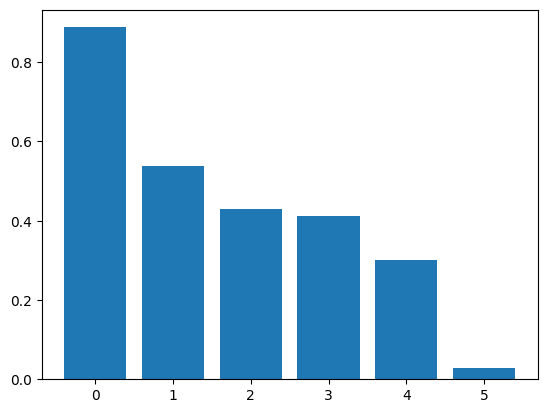

In [51]:
#accuracy bar plot for each category
accuracy = []
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    accuracy.append((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())
plt.bar(sorted(df["y_true"].round().astype(int).unique()), accuracy)

print(accuracy)

In [52]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_squared_error

Text(0.5, 1.0, 'Mean Squared Error for each week')

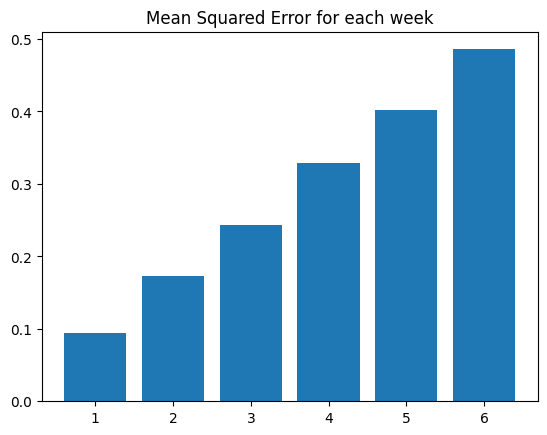

In [53]:
# MAE plot for each week
mse = []
for w in range(6):
    wdf = df[df['week']==w]
    mse.append(mean_squared_error(wdf['y_true'], wdf['y_pred']))
plt.bar(range(1,7), mse)
plt.title("Mean Squared Error for each week")

Text(0.5, 1.0, 'F1 score for each week')

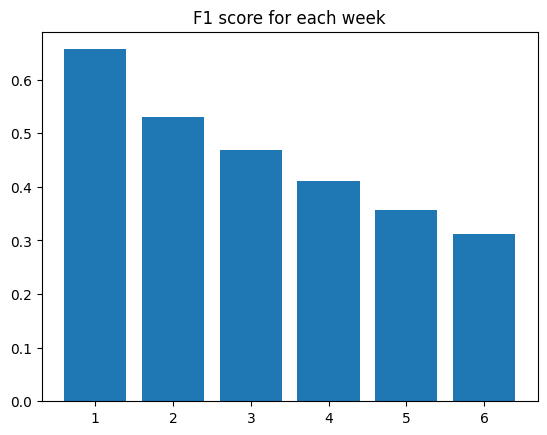

In [54]:
# F1 plot for each week
f1 = []
for w in range(6):
    wdf = df[df['week']==w]
    f1.append(f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro'))
plt.bar(range(1,7), f1)
plt.title("F1 score for each week")

(array([2.000e+00, 1.100e+01, 1.500e+01, 1.300e+01, 1.200e+01, 6.000e+00,
        1.300e+01, 2.100e+01, 3.300e+01, 5.000e+01, 8.700e+01, 1.250e+02,
        1.520e+02, 1.860e+02, 3.690e+02, 6.710e+02, 1.092e+03, 2.023e+03,
        4.733e+03, 7.660e+02, 6.340e+02, 6.450e+02, 6.300e+02, 6.280e+02,
        4.960e+02, 4.300e+02, 2.820e+02, 1.840e+02, 1.400e+02, 1.050e+02,
        8.800e+01, 7.200e+01, 5.200e+01, 3.800e+01, 1.200e+01, 1.000e+01,
        1.600e+01, 1.000e+01, 7.000e+00, 3.000e+00]),
 array([-2.40890765, -2.27987192, -2.15083618, -2.02180045, -1.89276471,
        -1.76372897, -1.63469324, -1.5056575 , -1.37662177, -1.24758603,
        -1.1185503 , -0.98951456, -0.86047883, -0.73144309, -0.60240735,
        -0.47337162, -0.34433588, -0.21530015, -0.08626441,  0.04277132,
         0.17180706,  0.30084279,  0.42987853,  0.55891427,  0.68795   ,
         0.81698574,  0.94602147,  1.07505721,  1.20409294,  1.33312868,
         1.46216441,  1.59120015,  1.72023589,  1.84927162,  1.9

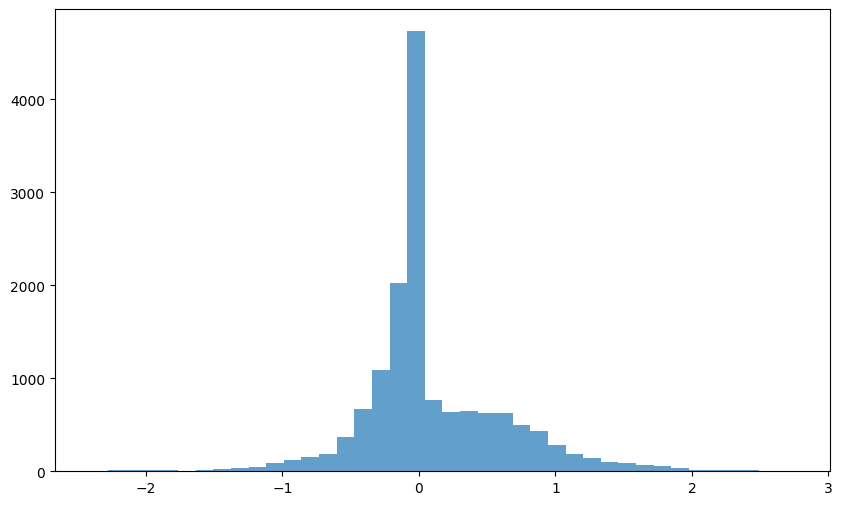

In [55]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

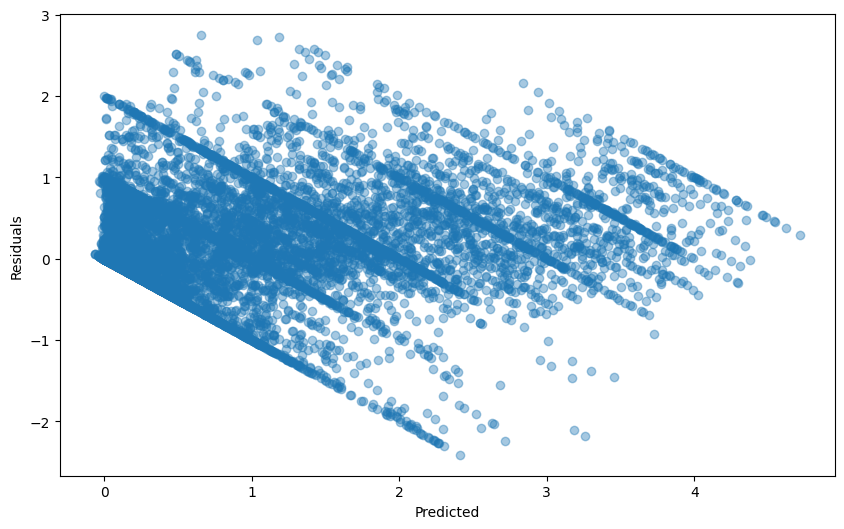

: 

In [56]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

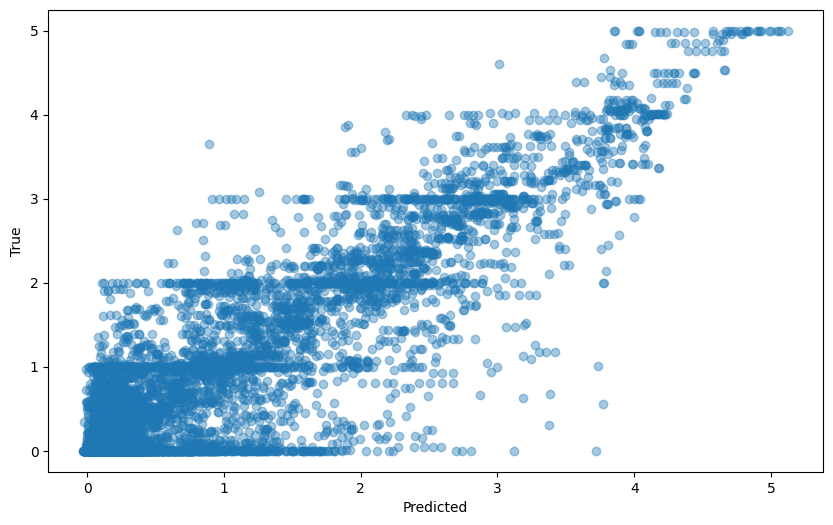

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")